In [1]:
import eli5
from eli5.sklearn import PermutationImportance
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from matplotlib import pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def build_keras_model_func(input, output, number_of_nodes_in_hidden_layer=3, number_of_hidden_layers=2, hidden_layer_activation='relu', output_layer_activation='linear', loss='mse'):
    def func():
        model = Sequential()
        model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation, input_shape=(len(input.columns),)))
        for _ in range(number_of_hidden_layers - 1):  
            model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation))
        model.add(Dense(1, activation=output_layer_activation))

        adam = Adam(lr=0.001)
        model.compile(loss=loss, optimizer=adam, metrics=['acc', 'mae'])
        
        return model
    
    return func

def find_outliers_isolation_forest(df):
    # find outliers using Isolation Forest
    isolation_forest = IsolationForest(contamination='auto', behaviour='new')
    isolation_forest.fit(df)
    return isolation_forest.predict(df)

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


   max_temperature_f  mean_temperature_f  min_temperature_f  max_dew_point_f  \
0           0.294118            0.566038           0.804878            0.875   
1           0.341176            0.584906           0.780488            0.875   
2           0.258824            0.490566           0.707317            0.775   
3           0.294118            0.528302           0.731707            0.850   
4           0.305882            0.584906           0.829268            0.875   

   mean_dew_point_f  min_dew_point_f  max_humidity  mean_humidity  \
0          0.857143         0.857143      0.883333       0.701493   
1          0.857143         0.857143      0.833333       0.626866   
2          0.809524         0.816327      0.883333       0.701493   
3          0.809524         0.795918      0.783333       0.597015   
4          0.904762         0.897959      0.883333       0.731343   

   min_humidity  max_sea_level_pressure_inches  ...  Holiday_Independence Day  \
0      0.632911        

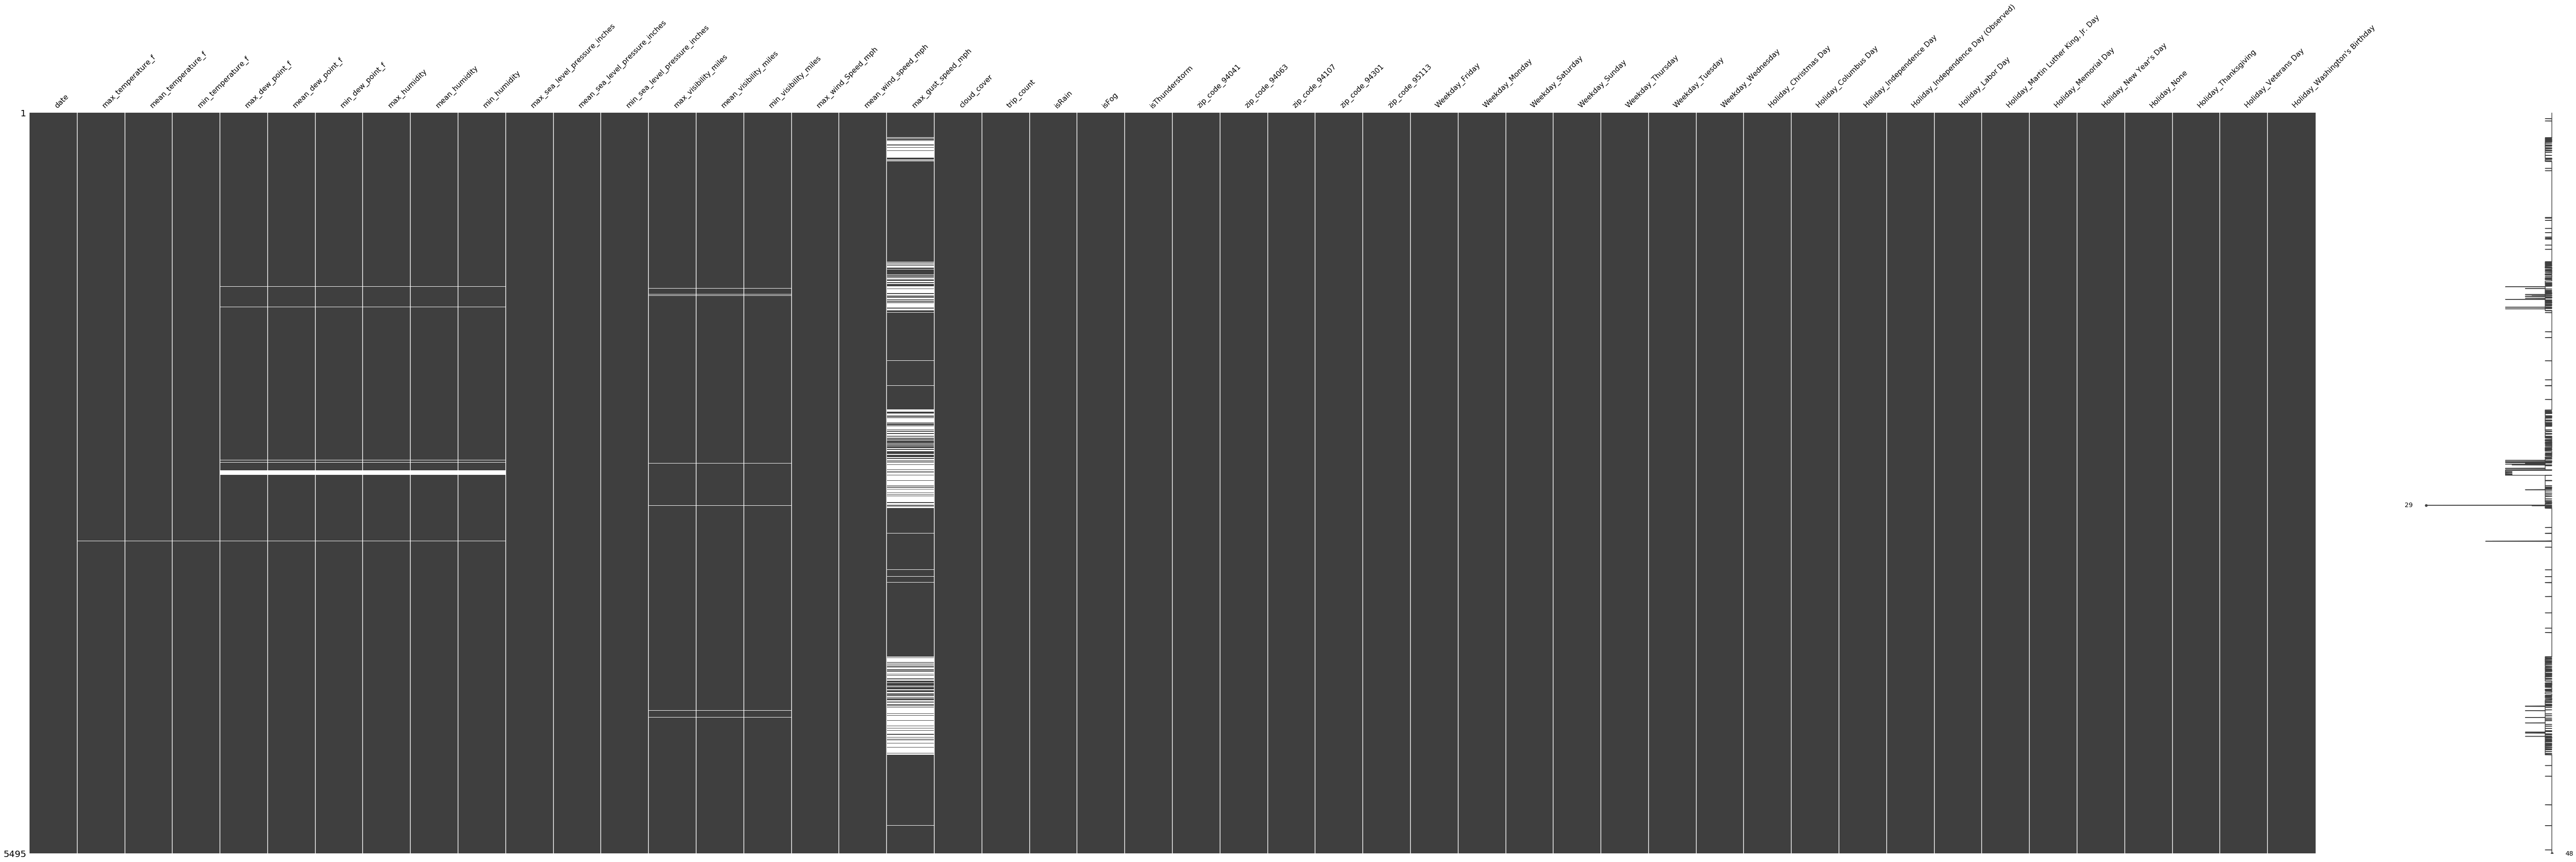

In [2]:
data = pd.read_csv("dataset/yes_date_set.csv")
missingno.matrix(data, figsize=(100, 30))
data = data.dropna()
time_series_data = data
data = data.drop('date', axis=1)

# find outliers using Isolation Forest
outliers_isolation = find_outliers_isolation_forest(data)
data.insert(0, "outliers_isolation", outliers_isolation, True)

# drop outliers based on Isolation Forest method
data = data.drop(data[data.outliers_isolation == -1.0].index)
data = data.drop('outliers_isolation', axis=1)

X = data.drop(['trip_count'], axis=1)
y = data[['trip_count']]

# normalize input
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X.head())
print(y.head())

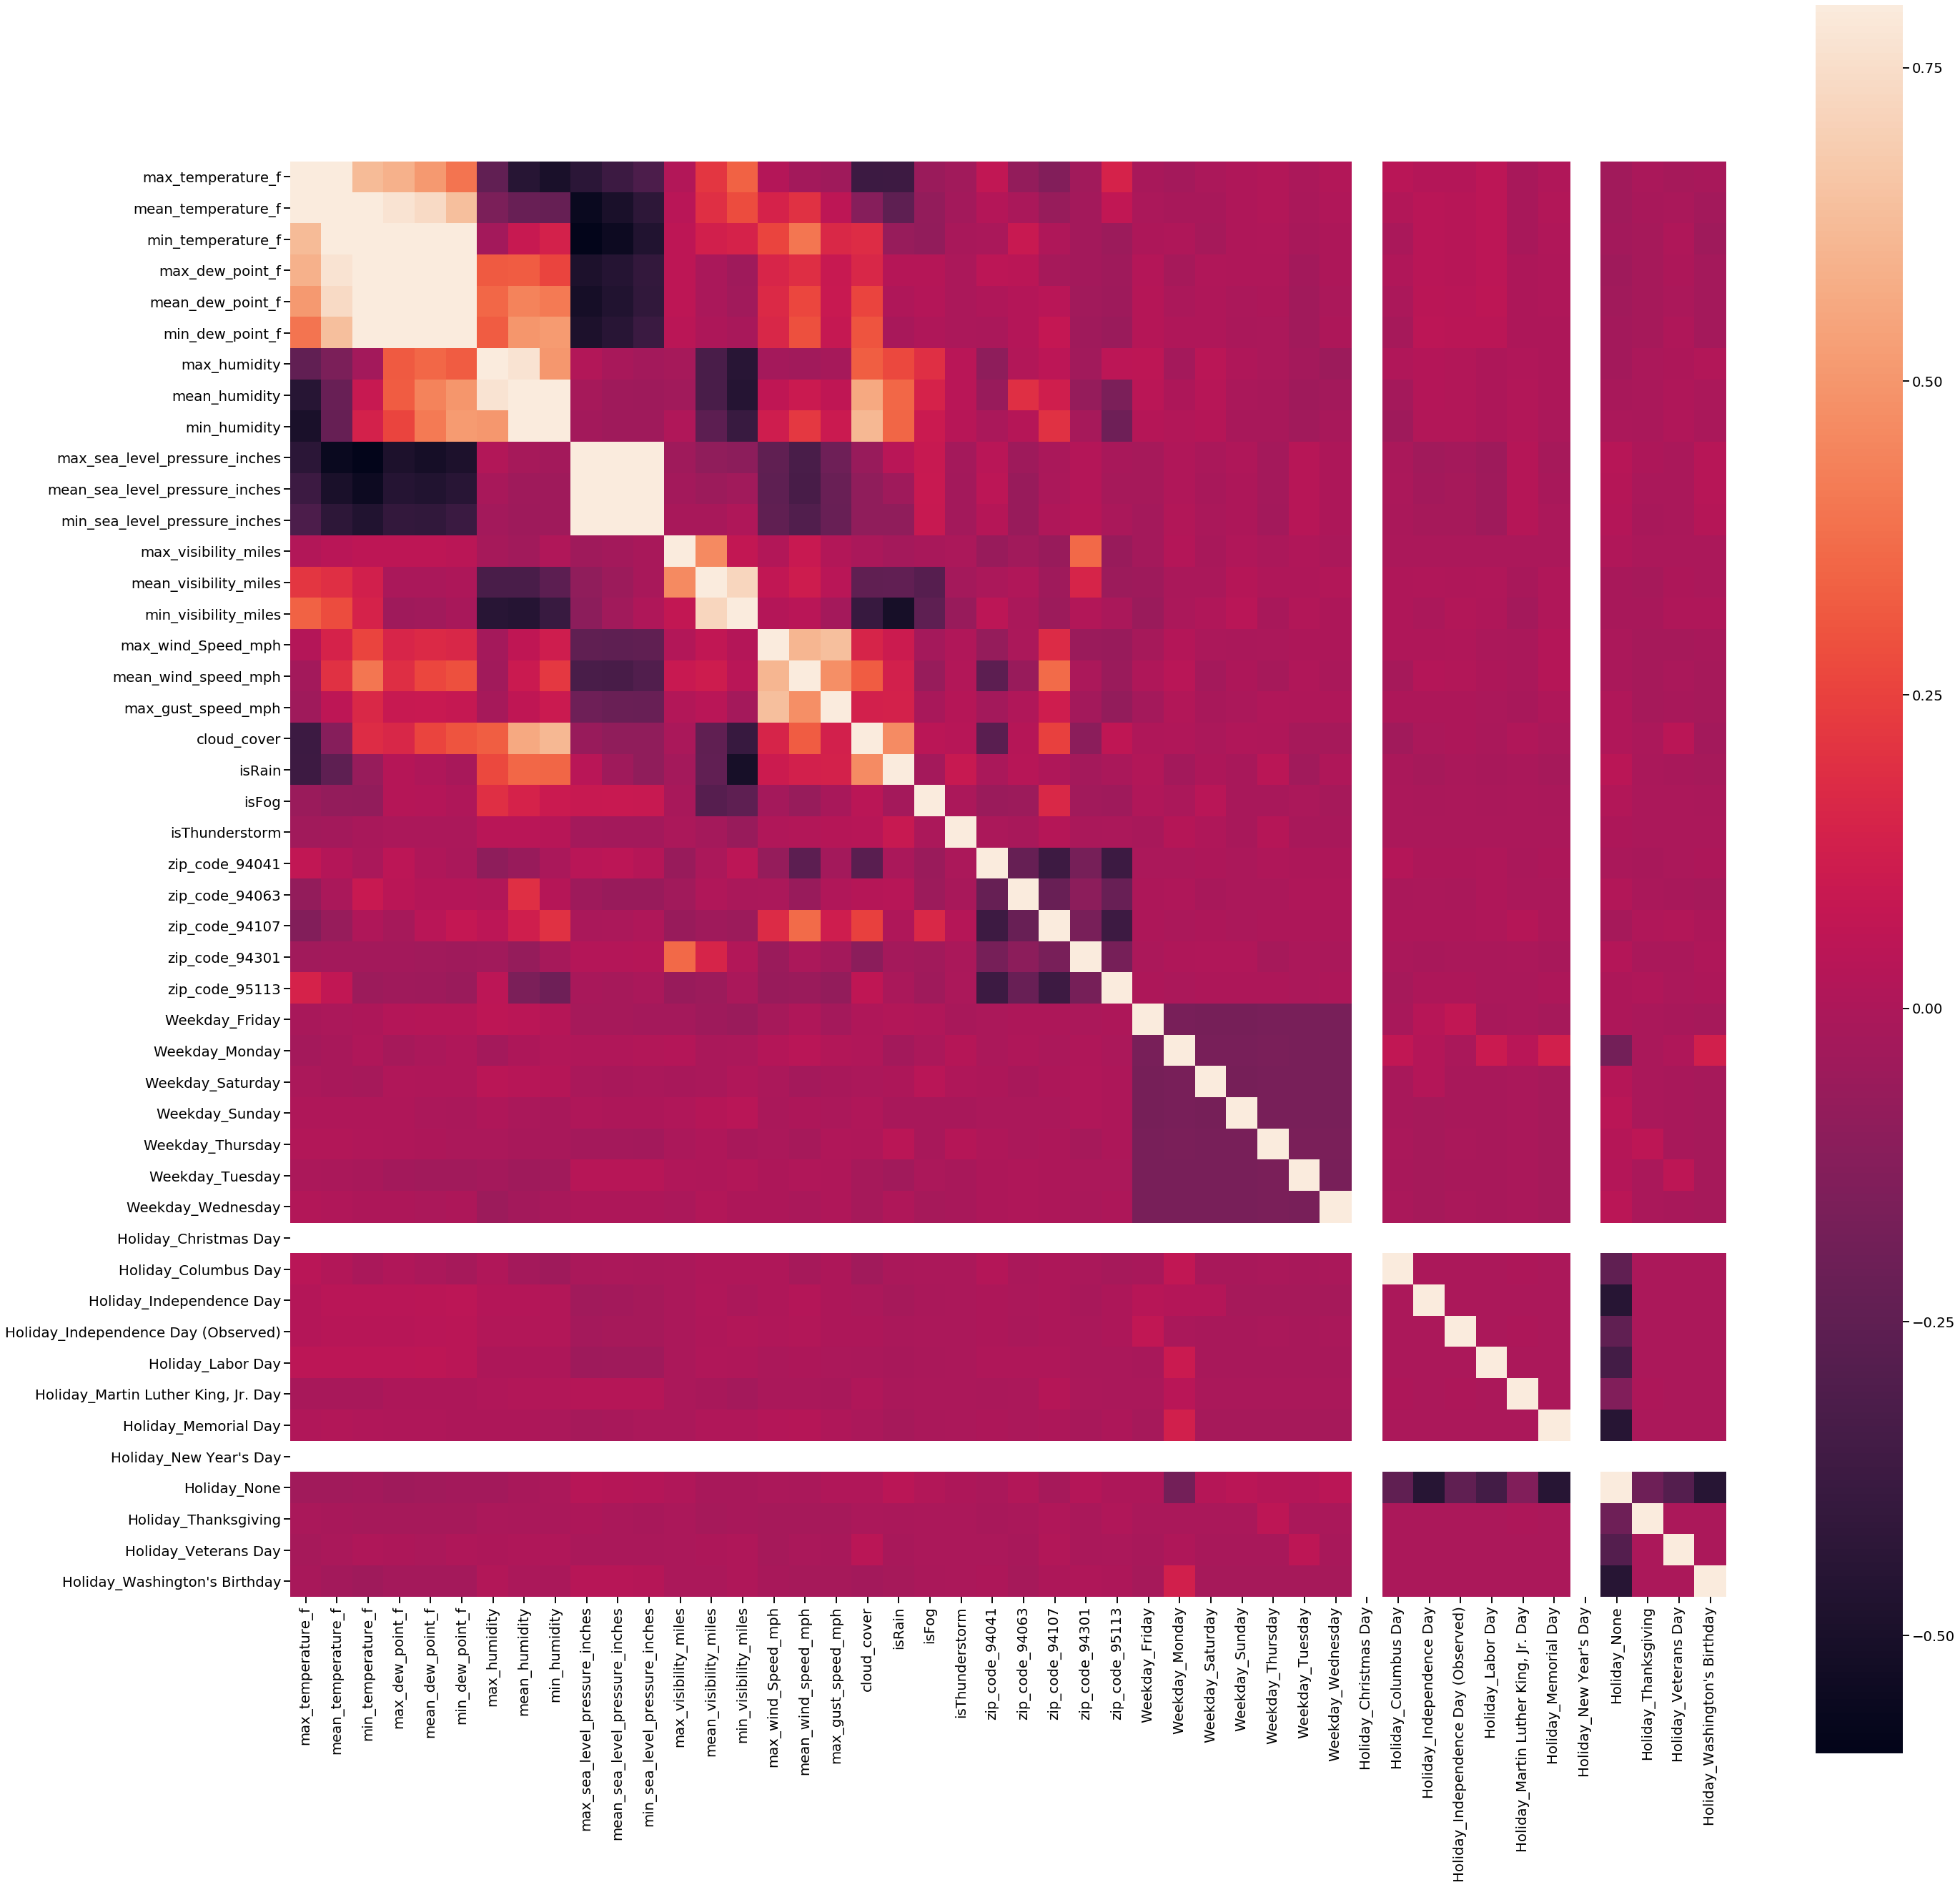

In [3]:
plt.figure(figsize=(45, 45))
sns.set_context('talk', font_scale=1.2)
sns.heatmap(X.corr(), vmax =.8, square=True)

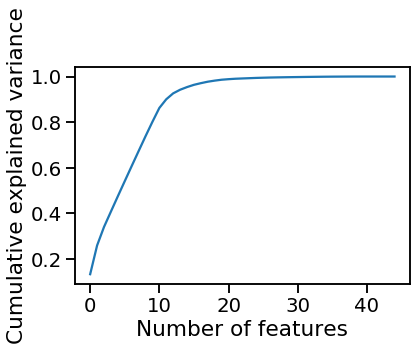

In [4]:
sns.set_context('talk', font_scale=1.2)

full_pca = PCA(n_components=45)
full_pca.fit(X)

plt.plot(np.cumsum(full_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [5]:
pca = PCA(n_components=30)
pca_X = pd.DataFrame(pca.fit_transform(X))

print(pca_X.shape)

(3811, 30)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X, y, test_size=0.3, random_state=50)

In [8]:
def grid_search(X_train, y_train, X_test, y_test):
    # perform grid search using multiple number of layers and nodes
    grid = pd.DataFrame(index=np.arange(3), columns=np.arange(4))
    
    # 1-3 hidden layers
    for i in range(4):
        number_of_hidden_layers = i + 1

        # 3, 6, 9, or 12 nodes
        for j in range(5):
            number_of_nodes_in_hidden_layer = j * 3 + 3
            
            # create and fit model with this number of layers/nodes
            func = build_keras_model_func(X_train, y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
            model = func()
            model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
            
            # store testing error of model
            testing_error = model.evaluate(X_test, y_test, batch_size=32)
            grid[i][j] = 1.0 - testing_error[1]
    
    return grid

error_grid = grid_search(pca_X_train, pca_y_train, pca_X_test, pca_y_test)
print(error_grid)

min_error = 0
min_row = 0
min_col = 0

for row in range(len(error_grid)):
    for col in range(len(error_grid.iloc[0, :])):
        error = error_grid.iloc[row, col]
        if error < min_error:
            min_error = error
            min_row = row
            min_col = col

number_of_hidden_layers = min_row + 1
number_of_nodes_in_hidden_layer = min_col * 3 + 3

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1144/1144 [==============================] - 0s 197us/step
          0         1         2         3
0  0.993007  0.980769  0.986888  0.986888
1  0.976399  0.975524  0.984266   0.97465
2  0.980769  0.972902   0.97028  0.982517


In [13]:
func = build_keras_model_func(X_train, y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
reg = KerasRegressor(build_fn=func, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=1)
history = reg.fit(X_train, y_train)

Train on 2667 samples, validate on 1144 samples
Epoch 1/100
2667/2667 [==============================] - 1s 363us/step - loss: 226020.1505 - acc: 0.0240 - mae: 244.1277 - val_loss: 205876.1404 - val_acc: 0.0288 - val_mae: 231.8071
Epoch 2/100
2667/2667 [==============================] - 0s 121us/step - loss: 225978.9062 - acc: 0.0240 - mae: 244.0471 - val_loss: 205838.4856 - val_acc: 0.0288 - val_mae: 231.7305
Epoch 3/100
2667/2667 [==============================] - 0s 184us/step - loss: 225939.4765 - acc: 0.0240 - mae: 243.9714 - val_loss: 205801.4532 - val_acc: 0.0288 - val_mae: 231.6552
Epoch 4/100
2667/2667 [==============================] - 0s 114us/step - loss: 225899.8916 - acc: 0.0240 - mae: 243.8934 - val_loss: 205764.0152 - val_acc: 0.0288 - val_mae: 231.5791
Epoch 5/100
2667/2667 [==============================] - 0s 146us/step - loss: 225860.5286 - acc: 0.0240 - mae: 243.8164 - val_loss: 205726.2103 - val_acc: 0.0288 - val_mae: 231.5022
Epoch 6/100
2667/2667 [==============

2667/2667 [==============================] - 0s 116us/step - loss: 224303.7883 - acc: 0.0225 - mae: 240.9371 - val_loss: 204248.9200 - val_acc: 0.0192 - val_mae: 228.6180
Epoch 46/100
2667/2667 [==============================] - 0s 111us/step - loss: 224265.1372 - acc: 0.0225 - mae: 240.8691 - val_loss: 204212.2174 - val_acc: 0.0192 - val_mae: 228.5496
Epoch 47/100
2667/2667 [==============================] - 0s 160us/step - loss: 224226.7125 - acc: 0.0225 - mae: 240.8017 - val_loss: 204175.6786 - val_acc: 0.0192 - val_mae: 228.4813
Epoch 48/100
2667/2667 [==============================] - 0s 123us/step - loss: 224188.2805 - acc: 0.0225 - mae: 240.7365 - val_loss: 204139.5389 - val_acc: 0.0192 - val_mae: 228.4138
Epoch 49/100
2667/2667 [==============================] - 0s 123us/step - loss: 224149.8086 - acc: 0.0225 - mae: 240.6695 - val_loss: 204102.6416 - val_acc: 0.0192 - val_mae: 228.3450
Epoch 50/100
2667/2667 [==============================] - 0s 120us/step - loss: 224111.4009 -

Epoch 90/100
2667/2667 [==============================] - 1s 316us/step - loss: 222583.8718 - acc: 0.0202 - mae: 238.2330 - val_loss: 202617.3101 - val_acc: 0.0280 - val_mae: 225.8684
Epoch 91/100
2667/2667 [==============================] - 0s 145us/step - loss: 222546.2540 - acc: 0.0202 - mae: 238.1797 - val_loss: 202581.5951 - val_acc: 0.0280 - val_mae: 225.8167
Epoch 92/100
2667/2667 [==============================] - 0s 156us/step - loss: 222508.4948 - acc: 0.0202 - mae: 238.1285 - val_loss: 202546.5123 - val_acc: 0.0280 - val_mae: 225.7659
Epoch 93/100
2667/2667 [==============================] - 0s 142us/step - loss: 222470.8961 - acc: 0.0202 - mae: 238.0765 - val_loss: 202510.3856 - val_acc: 0.0280 - val_mae: 225.7135
Epoch 94/100
2667/2667 [==============================] - 0s 139us/step - loss: 222432.8654 - acc: 0.0202 - mae: 238.0234 - val_loss: 202474.6161 - val_acc: 0.0157 - val_mae: 225.6617
Epoch 95/100
2667/2667 [==============================] - 0s 127us/step - loss: 

In [15]:
pca_func = build_keras_model_func(pca_X_train, pca_y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
pca_reg = KerasRegressor(build_fn=pca_func, batch_size=32, epochs=300, validation_data=(pca_X_test, pca_y_test), verbose=1)
pca_history = pca_reg.fit(pca_X_train, pca_y_train)

Train on 2667 samples, validate on 1144 samples
Epoch 1/300
2667/2667 [==============================] - 1s 430us/step - loss: 225943.6694 - acc: 0.0232 - mae: 243.9720 - val_loss: 205746.8551 - val_acc: 0.0288 - val_mae: 231.5900
Epoch 2/300
2667/2667 [==============================] - 0s 187us/step - loss: 225751.0285 - acc: 0.0229 - mae: 243.7359 - val_loss: 205519.0118 - val_acc: 0.0253 - val_mae: 231.3204
Epoch 3/300
2667/2667 [==============================] - 0s 128us/step - loss: 225468.8343 - acc: 0.0214 - mae: 243.4319 - val_loss: 205209.2484 - val_acc: 0.0262 - val_mae: 230.9868
Epoch 4/300
2667/2667 [==============================] - 0s 137us/step - loss: 225094.7149 - acc: 0.0206 - mae: 243.0577 - val_loss: 204822.8454 - val_acc: 0.0262 - val_mae: 230.5884
Epoch 5/300
2667/2667 [==============================] - 0s 152us/step - loss: 224644.3000 - acc: 0.0225 - mae: 242.6124 - val_loss: 204360.0306 - val_acc: 0.0253 - val_mae: 230.1203
Epoch 6/300
2667/2667 [==============

2667/2667 [==============================] - 1s 214us/step - loss: 168135.8768 - acc: 0.0139 - mae: 204.0186 - val_loss: 150962.1915 - val_acc: 0.0140 - val_mae: 191.8976
Epoch 46/300
2667/2667 [==============================] - 1s 273us/step - loss: 166195.9392 - acc: 0.0131 - mae: 202.9055 - val_loss: 149135.7127 - val_acc: 0.0201 - val_mae: 190.8186
Epoch 47/300
2667/2667 [==============================] - 1s 235us/step - loss: 164258.0618 - acc: 0.0165 - mae: 201.7561 - val_loss: 147294.3268 - val_acc: 0.0201 - val_mae: 189.7102
Epoch 48/300
2667/2667 [==============================] - 1s 368us/step - loss: 162313.1060 - acc: 0.0191 - mae: 200.6107 - val_loss: 145497.8220 - val_acc: 0.0149 - val_mae: 188.6262
Epoch 49/300
2667/2667 [==============================] - 1s 305us/step - loss: 160352.7667 - acc: 0.0191 - mae: 199.4512 - val_loss: 143698.1548 - val_acc: 0.0140 - val_mae: 187.5313
Epoch 50/300
2667/2667 [==============================] - 1s 349us/step - loss: 158400.7954 -

Epoch 90/300
2667/2667 [==============================] - 0s 89us/step - loss: 82202.1384 - acc: 0.0075 - mae: 155.6192 - val_loss: 71945.9052 - val_acc: 0.0105 - val_mae: 145.9488
Epoch 91/300
2667/2667 [==============================] - 0s 99us/step - loss: 80528.1927 - acc: 0.0064 - mae: 154.6305 - val_loss: 70440.4079 - val_acc: 0.0061 - val_mae: 145.0586
Epoch 92/300
2667/2667 [==============================] - 0s 102us/step - loss: 78880.0413 - acc: 0.0064 - mae: 153.6656 - val_loss: 68962.4140 - val_acc: 0.0070 - val_mae: 144.1721
Epoch 93/300
2667/2667 [==============================] - 0s 106us/step - loss: 77240.4779 - acc: 0.0071 - mae: 152.7687 - val_loss: 67474.7987 - val_acc: 0.0096 - val_mae: 143.3041
Epoch 94/300
2667/2667 [==============================] - 0s 90us/step - loss: 75606.2251 - acc: 0.0082 - mae: 151.8500 - val_loss: 66008.3950 - val_acc: 0.0061 - val_mae: 142.4769
Epoch 95/300
2667/2667 [==============================] - 0s 107us/step - loss: 74021.5201 - 

Epoch 135/300
2667/2667 [==============================] - 0s 115us/step - loss: 29861.2919 - acc: 0.0052 - mae: 117.7682 - val_loss: 26267.1170 - val_acc: 0.0044 - val_mae: 111.5605
Epoch 136/300
2667/2667 [==============================] - 0s 106us/step - loss: 29242.1449 - acc: 0.0052 - mae: 116.9016 - val_loss: 25761.1495 - val_acc: 0.0035 - val_mae: 110.7613
Epoch 137/300
2667/2667 [==============================] - 0s 95us/step - loss: 28643.5492 - acc: 0.0052 - mae: 116.0775 - val_loss: 25273.2324 - val_acc: 0.0052 - val_mae: 109.9599
Epoch 138/300
2667/2667 [==============================] - 0s 89us/step - loss: 28055.3476 - acc: 0.0052 - mae: 115.2226 - val_loss: 24796.8751 - val_acc: 0.0044 - val_mae: 109.1729
Epoch 139/300
2667/2667 [==============================] - 0s 122us/step - loss: 27493.0972 - acc: 0.0052 - mae: 114.3822 - val_loss: 24341.2369 - val_acc: 0.0052 - val_mae: 108.3383
Epoch 140/300
2667/2667 [==============================] - 0s 92us/step - loss: 26951.8

2667/2667 [==============================] - 0s 131us/step - loss: 15552.2147 - acc: 0.0090 - mae: 82.9227 - val_loss: 14944.1748 - val_acc: 0.0079 - val_mae: 78.9431
Epoch 181/300
2667/2667 [==============================] - 0s 111us/step - loss: 15408.5063 - acc: 0.0097 - mae: 82.2764 - val_loss: 14823.8420 - val_acc: 0.0044 - val_mae: 78.3586
Epoch 182/300
2667/2667 [==============================] - 0s 109us/step - loss: 15265.5982 - acc: 0.0082 - mae: 81.6265 - val_loss: 14706.4246 - val_acc: 0.0044 - val_mae: 77.8039
Epoch 183/300
2667/2667 [==============================] - 0s 129us/step - loss: 15123.8568 - acc: 0.0086 - mae: 80.9982 - val_loss: 14582.9133 - val_acc: 0.0044 - val_mae: 77.2331
Epoch 184/300
2667/2667 [==============================] - 0s 117us/step - loss: 14978.5829 - acc: 0.0094 - mae: 80.4020 - val_loss: 14472.0643 - val_acc: 0.0052 - val_mae: 76.7227
Epoch 185/300
2667/2667 [==============================] - 0s 109us/step - loss: 14836.7561 - acc: 0.0086 - m

2667/2667 [==============================] - 0s 109us/step - loss: 10051.7151 - acc: 0.0116 - mae: 59.3515 - val_loss: 10370.2376 - val_acc: 0.0079 - val_mae: 58.0606
Epoch 226/300
2667/2667 [==============================] - 0s 132us/step - loss: 9960.6068 - acc: 0.0082 - mae: 58.9062 - val_loss: 10288.7889 - val_acc: 0.0087 - val_mae: 57.6831
Epoch 227/300
2667/2667 [==============================] - 0s 105us/step - loss: 9871.6175 - acc: 0.0094 - mae: 58.5059 - val_loss: 10214.5677 - val_acc: 0.0079 - val_mae: 57.3463
Epoch 228/300
2667/2667 [==============================] - 0s 101us/step - loss: 9784.2292 - acc: 0.0094 - mae: 58.1125 - val_loss: 10140.3304 - val_acc: 0.0087 - val_mae: 56.9780
Epoch 229/300
2667/2667 [==============================] - 0s 108us/step - loss: 9698.1618 - acc: 0.0090 - mae: 57.7236 - val_loss: 10058.8425 - val_acc: 0.0087 - val_mae: 56.6070
Epoch 230/300
2667/2667 [==============================] - 0s 130us/step - loss: 9614.3001 - acc: 0.0082 - mae: 5

Epoch 271/300
2667/2667 [==============================] - 0s 112us/step - loss: 7132.1016 - acc: 0.0157 - mae: 44.5647 - val_loss: 7931.2569 - val_acc: 0.0122 - val_mae: 44.8845
Epoch 272/300
2667/2667 [==============================] - 0s 96us/step - loss: 7094.1152 - acc: 0.0169 - mae: 44.3240 - val_loss: 7896.0633 - val_acc: 0.0131 - val_mae: 44.6728
Epoch 273/300
2667/2667 [==============================] - 0s 96us/step - loss: 7057.2384 - acc: 0.0154 - mae: 44.1349 - val_loss: 7862.1376 - val_acc: 0.0131 - val_mae: 44.4805
Epoch 274/300
2667/2667 [==============================] - 0s 112us/step - loss: 7020.6821 - acc: 0.0184 - mae: 43.8933 - val_loss: 7830.3712 - val_acc: 0.0157 - val_mae: 44.2737
Epoch 275/300
2667/2667 [==============================] - 0s 105us/step - loss: 6984.4886 - acc: 0.0176 - mae: 43.6941 - val_loss: 7804.6225 - val_acc: 0.0140 - val_mae: 44.0808
Epoch 276/300
2667/2667 [==============================] - 0s 95us/step - loss: 6949.3297 - acc: 0.0176 - m

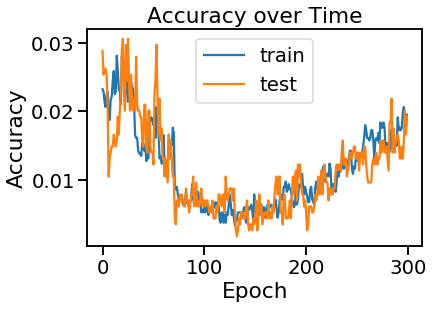

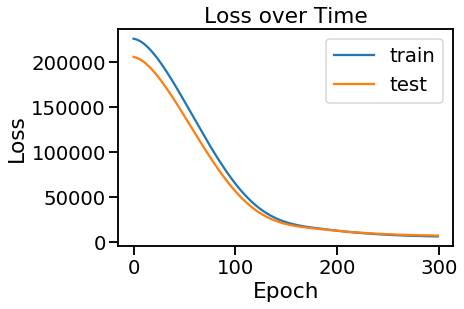

In [16]:
acc_fig, acc_ax = plt.subplots()
acc_ax.plot(pca_history.history['acc'])
acc_ax.plot(pca_history.history['val_acc'])
acc_ax.set_title('Accuracy over Time')
acc_ax.set_xlabel('Epoch')
acc_ax.set_ylabel('Accuracy')
acc_ax.legend(['train', 'test'])

loss_fig, loss_ax = plt.subplots()
loss_ax.plot(pca_history.history['loss'])
loss_ax.plot(pca_history.history['val_loss'])
loss_ax.set_title('Loss over Time')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.legend(['train', 'test'])

plt.show()

In [ ]:
test_predict = pca_reg.predict(pca_X_test)
ylist = y_test["trip_count"].tolist()

for i in range(len(ylist)):
    # y actual vs y predicted
    print(str(ylist[i]), "  ", str(test_predict[i]))

c = 0
for i in range(len(ylist)):
    #print(ylist[i]-test_predict[i])
    c = c + ylist[i]-test_predict[i]
print("============")
#printing if we were short or over the amount of bikes we need
# if negative we have predicted more bikes than we actually need
print(c)
print("============")
c = 0
for i in range(len(ylist)):
    #adding up the total amount of trips taken
    c = c + ylist[i]
print("============")
print(c)
print("============")

1144/1144 [==============================] - 1s 649us/step
20    9.774528
34    9.774528
257    371.8573
17    -15.289937
4    9.774528
60    68.48249
22    33.59719
1122    1103.0067
31    74.633965
25    9.774528
28    17.422396
35    32.062828
1    9.774528
42    31.516655
7    -13.970342
80    77.42727
2    17.492012
20    9.774528
374    424.24756
45    50.02894
74    62.9573
63    81.09872
13    9.774528
33    38.722557
17    -32.256348
2    9.407851
15    9.774528
25    35.51449
5    4.8755445
56    72.79665
50    47.756493
12    -40.885235
5    -24.287556
24    61.23458
944    1009.36316
13    9.774528
797    1128.6132
22    9.774528
25    33.892487
13    9.774528
7    13.447791
43    35.88021
361    411.31976
33    9.774528
22    26.259438
9    20.916893
2    9.774528
383    407.8229
36    25.303307
39    53.48562
82    71.49584
19    9.107764
129    208.45102
1013    1039.6489
1155    1071.7833
0    9.774528
55    35.340202
279    406.56146
1086    1099.4403
1095    988.795
7

26    43.045525
54    52.061745
85    65.48084
9    2.1123877
448    466.30676
1041    1081.3278
33    -48.829727
12    9.774528
30    32.105034
377    386.66843
9    -20.119892
31    40.59542
309    337.33167
36    42.98649
22    -11.190644
1038    1001.9537
1000    985.8972
68    56.116432
7    23.661186
1056    1120.5172
6    19.143501
49    59.142937
22    9.774528
67    21.68496
0    20.092522
4    6.1661444
4    -118.08868
14    44.964256
26    30.138588
352    349.0139
84    72.77099
1    8.480567
31    9.774528
50    9.774528
36    56.054314
24    15.177115
85    72.30041
57    86.14846
17    40.109886
21    9.774528
43    46.66372
1004    1073.6813
969    910.0419
6    9.774528
17    9.774528
1194    1003.2638
5    2.8584738
24    9.774528
2    -1.8238764
34    39.89257
10    -16.503105
12    9.774528
70    78.727135
42    73.35754
46    41.172295
38    44.228508
54    47.31585
4    13.912665
63    38.884743
278    390.06573
11    0.885087
45    58.107933
31    35.821007
3    

In [ ]:
perm = PermutationImportance(reg, random_state=32).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

In [ ]:
entries_94107 = time_series_data[time_series_data["zip_code_94107"] == 1]
entries_94041 = time_series_data[time_series_data["zip_code_94041"] == 1]
entries_95113 = time_series_data[time_series_data["zip_code_95113"] == 1]
entries_94063 = time_series_data[time_series_data["zip_code_94063"] == 1]
entries_94301 = time_series_data[time_series_data["zip_code_94301"] == 1]

In [ ]:
# Ordinary Least Squares (TODO)

In [ ]:
# LSTM (TODO)